### Initial imports and cluster setup

In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import jaccard_score

In [2]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45141 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-48aaytsk', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-5x246cdi', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-a1g4kp34', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-krrpu3cr', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdo

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45141/status,
Dashboard: http://127.0.0.1:45141/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42711,Workers: 8
Dashboard: http://127.0.0.1:45141/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:35457,Total threads: 2
Dashboard: http://127.0.0.1:38253/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:40133,


### Set parameters

In [3]:
# general input parameters
suffix = '_rgb_tpi_5cm'
cell_size = 5.0
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

# september inputs
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
colony_active_f = './ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif'
colony_old_f = './ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif'

# july inputs
shps_f_list_july = glob.glob('./cnn_pred_results_july/burrow_pts_pred_*' + suffix + '.shp')
colony_active_f_july = './ground_data/PdogMapping_July2021/July2021_active_yrs.tif'
colony_old_f_july = './ground_data/PdogMapping_July2021/July2021_old_yrs.tif'

# processing prameters
#---Only set radius or focal area, not both. Other should be set to None
radius_m = 25
focal_area_ha = None
burrow_area_thresh = None  #minimum burrow size
pts_thresh = 6.0  #burrow pts required within radius_m to be part of a colony
win_size = 11  #window size (in pixels) for connectivity calculations

# use to create radius or focal area from the other
if focal_area_ha is None:
    focal_area_ha = (np.pi * radius_m**2) * 1e-4
if radius_m is None:
    radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi


### Additional helper functions

##### General functions

In [4]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

def apply_slope(y):
    from sklearn.linear_model import LinearRegression
    X = np.arange(0, len(y))
    if len(y[~np.isnan(y)]) > 3:
        ts = LinearRegression().fit(X[~np.isnan(y)].reshape(-1, 1), y[~np.isnan(y)])
        return ts.coef_
    else:
        return np.nan

##### Connectivity functions

In [5]:
from scipy.signal import convolve2d

def pf_func(binary, fws, shape='circle'):
    # density function
    if shape == 'circle':
        w_pf = convolution.circle_kernel(1, 1, radius=np.ceil(fws/2))
    else:
        w_pf = np.ones((fws, fws))
    return convolve2d(binary, w_pf, 'same') / fws**2


def pff_calc(binary, fws):
    s = int((fws - 1) / 2)
    ff_pairs = []
    nf_pairs = []
    for j in range(-s, s + 1):
        for i in range(-s, s):
            ff_pairs.append(binary[i, j] and binary[i+1, j])
            nf_pairs.append(binary[i, j] or binary[i+1, j])
    for i in range(-s, s + 1):
        for j in range(-s, s):
            ff_pairs.append(binary[i, j] and binary[i, j+1])
            nf_pairs.append(binary[i, j] or binary[i, j+1])
    if sum([int(x) for x in nf_pairs]) == 0:
        pff = 0
    else:
        pff = sum([int(x) for x in ff_pairs]) / sum([int(x) for x in nf_pairs])
    return pff


def pff_func(binary, fws, pad_method='edge'):
    #connectivity function
    s = int((fws - 1) / 2)
    arr_out = np.ones_like(binary) * np.nan
    binary_pad = np.pad(binary, fws, pad_method)
    for nr in tqdm(range(fws-1, binary.shape[0] + fws)):
        for nc in range(fws-1, binary.shape[1] + fws):
            rs = nr - s
            if rs < 0:
                rs = nr
            rf = rs + fws
            if rf > binary_pad.shape[0]:
                rf = nr
                rs = nr - fws
            cs = nc - s
            if cs < 0:
                cs = nc
            cf = cs + fws
            if cf > binary_pad.shape[1]:
                cf = nc
                cs = cf - fws
            #print(rs, rf, cs, cf)
            arr_tmp = binary_pad[rs:rf, cs:cf]
            if np.all(arr_tmp == 0):
                arr_out[nr - fws, nc - fws] = 0
            else:
                arr_out[nr - fws, nc - fws] = pff_calc(arr_tmp, fws)
    return arr_out
#def pff_func(binary, fws):
#    np.vectorize()

def frag_index(binary, pf, pff, shape='circle', fws=None, cutoff_dict=None):
    # set correction factor to account for whether a circular window was used to calculate density
    if shape=='circle' and fws is not None:
        corr_fact = np.sum(convolution.circle_kernel(1, 1, radius=np.ceil(fws/2))) / np.sum(np.ones((fws, fws)))
    elif shape=='circle' and fws is None:
        print('ERROR: circular kernel set but no window size specified. This is not allowed.')
    else:
        corr_fact = 1.0
    
    arr_out = np.ones_like(binary) * np.nan
        
    arr_out[(pf >= 0.90*corr_fact)] = 1
    
    arr_out[(pf >= 0.60*corr_fact) & (pf < 0.90*corr_fact) & 
            (pf >= pff*corr_fact)] = 2
    
    arr_out[(pf >= 0.60*corr_fact) & (pf < 0.90*corr_fact) & 
            (pf < pff*corr_fact)] = 4
    
    arr_out[(pf >= 0.40*corr_fact) & (pf < 0.60*corr_fact)] = 5
    
    arr_out[(binary != 0) & (pf < 0.40*corr_fact)] = 7 
    
    return arr_out

### Preprocessing

In [6]:
# rasterize pasture data
cper = gpd.read_file(cper_f)
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry.buffer(cell_size), cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))
cper_xr = cper_xr.where(cper_xr != 0)

In [7]:
# rasterize burrow location data 
pts_list = []
pts_list_july = []
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        shps_f_list_sub_july = [x for x in shps_f_list_july if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            if burrow_area_thresh is not None:
                pts_tmp['area'] = pts_tmp['area'].astype('int')
                pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list.append(pts_xr.where(pts_xr != 0))
        for f in shps_f_list_sub_july:
            pts_tmp_july = gpd.read_file(f)
            pts_tmp_july = pts_tmp_july[pts_tmp_july.geometry != None]
            if burrow_area_thresh is not None:
                pts_tmp_july['area'] = pts_tmp_july['area'].astype('int')
                pts_tmp_july = pts_tmp_july[pts_tmp_july['area'] >= burrow_area_thresh]
            pts_xr_july = shp2mask(pts_tmp_july.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list_july.append(pts_xr_july.where(pts_xr_july != 0))
            
pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))
pts_all_july_xr = xr.DataArray(np.nanmean(pts_list_july, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]
/tmp/ipykernel_5953/863866309.py:30: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),
/tmp/ipykernel_5953/863866309.py:33: RuntimeWarning: Mean of empty slice
  pts_all_july_xr = xr.DataArray(np.nanmean(pts_list_july, axis=0),


In [8]:
# load colony maps
da_active = riox.open_rasterio(colony_active_f).squeeze()
da_old = riox.open_rasterio(colony_old_f).squeeze()

da_active_july = riox.open_rasterio(colony_active_f_july).squeeze()
da_old_july = riox.open_rasterio(colony_old_f_july).squeeze()

### Create and save burrow density/sum maps

In [9]:
# define save location
if not os.path.exists('./cnn_pred_results/tifs/'):
    os.mkdir('./cnn_pred_results/tifs/')

In [10]:
# september
cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
pts_xr_sum = focal.apply(pts_all_xr,
                     kernel,
                     focal._calc_sum)
#pts_xr_sum.rio.to_raster('./cnn_pred_results/tifs/burrow_sum_' + str(int(radius_m)) + 'm' + suffix + '.tif')

# july
pts_xr_july_sum = focal.apply(pts_all_july_xr,
                     kernel,
                     focal._calc_sum)
#pts_xr_july_sum.rio.to_raster('./cnn_pred_results/tifs/burrow_sum_july' + str(int(radius_m)) + 'm' + suffix + '.tif')

In [11]:
pts_xr_change = pts_xr_sum - pts_xr_july_sum
#pts_xr_change.rio.to_raster('./cnn_pred_results/tifs/burrow_sum_change' + str(int(radius_m)) + 'm' + suffix + '.tif')

In [12]:
#pts_density_xr = pts_xr_sum / focal_area_ha
#pts_density_xr.rio.to_raster('./cnn_pred_results/tifs/burrow_density' + suffix + '.tif')

#pts_density_july_xr = pts_xr_july_sum / focal_area_ha
#pts_density_july_xr.rio.to_raster('./cnn_pred_results/tifs/burrow_density_july' + suffix + '.tif')

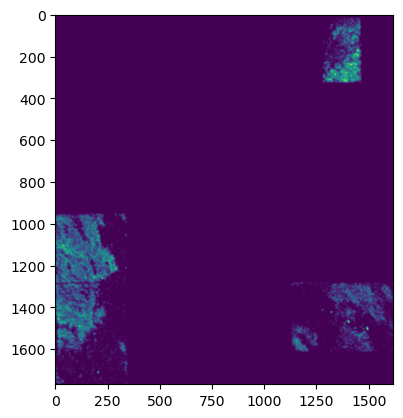

<AxesSubplot:>

In [13]:
show(pts_xr_july_sum.data)

### Create and save connectivity maps

In [14]:
from skimage.filters.rank import majority
from scipy.ndimage import binary_fill_holes

In [55]:
arr_pf = pf_func((pts_xr_sum >= pts_thresh).data.astype('int'), win_size, 'circle')
arr_pff = pff_func((pts_xr_sum >= pts_thresh).data.astype('int'), win_size)
arr_conn = frag_index((pts_xr_sum >= pts_thresh).data.astype('int'), 
                      arr_pf, arr_pff, 'circle', win_size).astype('uint8')

cleanup_kernel = convolution.circle_kernel(1, 1, radius=2)
arr_conn = majority(arr_conn, footprint=cleanup_kernel)

arr_core = np.isin(arr_conn, [1, 2]).astype('int')
arr_core_filled = binary_fill_holes(arr_core)
arr_conn[(arr_core_filled == 1) & (arr_core==0)] = 3

arr_possible = np.isin(arr_conn, [1, 2, 4, 5]).astype('int')
arr_possible_filled = binary_fill_holes(arr_possible)
arr_conn[(arr_possible_filled == 1) & (arr_possible==0) & np.isin(arr_conn, [0, 7])] = 6

xr_conn = xr.DataArray(arr_conn,
                       coords=(cper_xr.y, cper_xr.x),
                       dims=('y', 'x'))
xr_conn = xr_conn.rio.set_crs(32613)
xr_conn = xr_conn.where(da_active.notnull())
xr_conn.astype('uint8').rio.to_raster('cnn_pred_results/tifs/burrow_connectivity_25m_6bur_' + str(win_size) + 'px' + suffix + '.tif')

xr_pf = xr.DataArray(arr_pf,
                       coords=(cper_xr.y, cper_xr.x),
                       dims=('y', 'x'))
xr_pf = xr_pf.rio.set_crs(32613)
#xr_pf.rio.to_raster('cnn_pred_results/tifs/burrow_pf_25m_6bur_' + str(win_size) + 'px' + suffix + '.tif')

xr_pff = xr.DataArray(arr_pff,
                       coords=(cper_xr.y, cper_xr.x),
                       dims=('y', 'x'))
xr_pff = xr_pff.rio.set_crs(32613)
#xr_pff.rio.to_raster('cnn_pred_results/tifs/burrow_pff_25m_6bur_' + str(win_size) + 'px' + suffix + '.tif')

100%|███████████████████████████████████████████████████████████████████████████████| 1770/1770 [00:42<00:00, 41.99it/s]


In [56]:
arr_pf_july = pf_func((pts_xr_july_sum >= pts_thresh).data.astype('int'), win_size, 'circle')
arr_pff_july = pff_func((pts_xr_july_sum >= pts_thresh).data.astype('int'), win_size)
arr_conn_july = frag_index((pts_xr_july_sum >= pts_thresh).data.astype('int'), 
                           arr_pf_july, arr_pff_july, 'circle', win_size).astype('uint8')
cleanup_kernel = convolution.circle_kernel(1, 1, radius=2)
arr_conn_july = majority(arr_conn_july, footprint=cleanup_kernel)

arr_core = np.isin(arr_conn_july, [1, 2]).astype('int')
arr_core_filled = binary_fill_holes(arr_core)
arr_conn_july[(arr_core_filled == 1) & (arr_core==0)] = 3

arr_possible = np.isin(arr_conn_july, [1, 2, 4, 5]).astype('int')
arr_possible_filled = binary_fill_holes(arr_possible)
arr_conn_july[(arr_possible_filled == 1) & (arr_possible==0) & np.isin(arr_conn_july, [0, 7])] = 6

xr_conn_july = xr.DataArray(arr_conn_july,
                       coords=(cper_xr.y, cper_xr.x),
                       dims=('y', 'x'))
xr_conn_july = xr_conn_july.rio.set_crs(32613)
xr_conn_july = xr_conn_july.where(da_active_july.notnull())
xr_conn_july.astype('uint8').rio.to_raster('cnn_pred_results/tifs/burrow_connectivity_july_25m_6bur_' + str(win_size) + 'px' + suffix + '.tif')

xr_pf_july = xr.DataArray(arr_pf_july,
                       coords=(cper_xr.y, cper_xr.x),
                       dims=('y', 'x'))
xr_pf_july = xr_pf_july.rio.set_crs(32613)
#xr_pf_july.rio.to_raster('cnn_pred_results/tifs/burrow_pf_july_25m_6bur_' + str(win_size) + 'px' + suffix + '.tif')

xr_pff_july = xr.DataArray(arr_pff_july,
                       coords=(cper_xr.y, cper_xr.x),
                       dims=('y', 'x'))
xr_pff_july = xr_pff_july.rio.set_crs(32613)
#xr_pff_july.rio.to_raster('cnn_pred_results/tifs/burrow_pff_july_25m_6bur_' + str(win_size) + 'px' + suffix + '.tif')

100%|███████████████████████████████████████████████████████████████████████████████| 1770/1770 [00:39<00:00, 45.06it/s]


### Bring in biomass and cover data

In [17]:
hls_xr = riox.open_rasterio('/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2021_gcloud.nc',
                            decode_times=True,
                            chunks={'date': -1, 'x': 50, 'y': 50},
                            masked=True)
hls_xr

<xarray.Dataset>
Dimensions:      (date: 365, x: 323, y: 325)
Coordinates:
  * date         (date) object 2021-01-01 00:00:00 ... 2021-12-31 00:00:00
  * x            (x) float64 -1.167e+07 -1.167e+07 ... -1.165e+07 -1.165e+07
  * y            (y) float64 4.993e+06 4.993e+06 4.993e+06 ... 4.98e+06 4.98e+06
    spatial_ref  int64 0
Data variables:
    BARE         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    GREEN        (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    SD           (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    LITT         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass      (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass_SE   (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NDVI         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    DRYVEG       (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NONVEG       (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
Attributes:
    add_offset:    0
    scale_factor:  1
    _FillValue:    3.402823466385289e+38

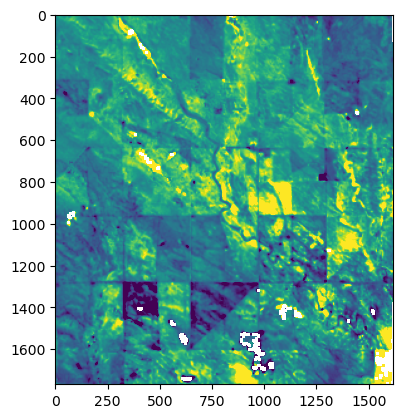

<AxesSubplot:>

In [18]:
bm_slope = xr.apply_ufunc(apply_slope,
                          hls_xr['Biomass'].isel(date=slice(200, 250)),
                          input_core_dims=[['date']],
                          vectorize=True,
                          dask='parallelized')
bm_slope = bm_slope.rio.reproject('EPSG:32613').compute()
bm_slope = bm_slope.where((bm_slope > -20) & (bm_slope < 20))
bm_slope_z = (bm_slope - bm_slope.mean()) / bm_slope.std()
bm_slope_z = bm_slope_z.reindex_like(pts_xr_sum, method='nearest')
show(bm_slope_z.data, clim=(-2.0, 2.0))

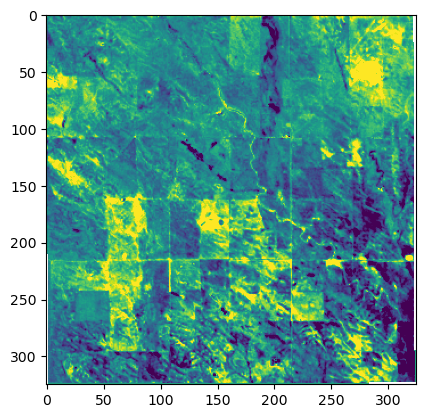

<AxesSubplot:>

In [19]:
bare_slope = xr.apply_ufunc(apply_slope,
                          hls_xr['BARE'].isel(date=slice(200, 250)),
                          input_core_dims=[['date']],
                          vectorize=True,
                          dask='parallelized')
bare_slope = bare_slope.rio.reproject('EPSG:32613').compute()
bare_slope = bare_slope.where((bare_slope > -20.0) & (bare_slope < 20.0))
bare_slope_z = (bare_slope - bare_slope.mean()) / bare_slope.std()
show(bare_slope_z.data, clim=(-2.0, 2.0))

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


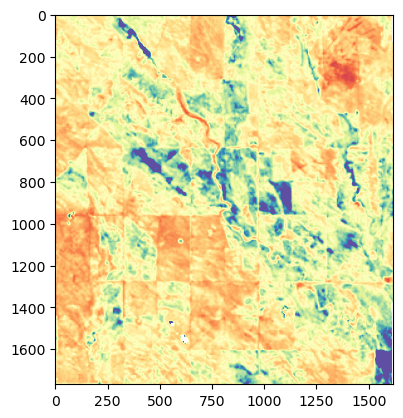

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [20]:
bm_sub = hls_xr['Biomass'].isel(date=slice(235, 265)).mean(dim='date').rio.reproject('EPSG:32613').compute()
bm_sub = bm_sub.where(bm_sub != bm_sub.rio.nodata)
bm_sub = bm_sub.reindex_like(pts_xr_sum, method='nearest')
bm_z = (bm_sub - bm_sub.mean()) / bm_sub.std()
show(bm_z.data, cmap='Spectral', clim=(-3.0, 3.0))

bm_sub_july = hls_xr['Biomass'].isel(date=slice(185, 215)).mean(dim='date').rio.reproject('EPSG:32613').compute()
bm_sub_july = bm_sub_july.where(bm_sub_july != bm_sub_july.rio.nodata)
bm_sub_july = bm_sub_july.reindex_like(pts_xr_july_sum, method='nearest')
bm_z_july = (bm_sub_july - bm_sub_july.mean()) / bm_sub_july.std()

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


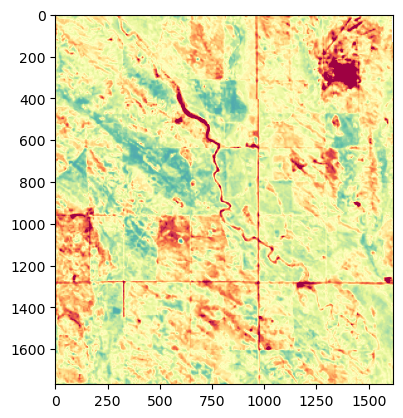

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [21]:
bare_sub = hls_xr['BARE'].isel(date=slice(235, 265)).mean(dim='date').rio.reproject('EPSG:32613').compute()
bare_sub = bare_sub.where(bare_sub != bare_sub.rio.nodata)
bare_sub = bare_sub.reindex_like(pts_xr_sum, method='nearest')
bare_z = (bare_sub - bare_sub.mean()) / bare_sub.std()
show(bare_z.data, cmap='Spectral_r', clim=(-3.0, 3.0))

bare_sub_july = hls_xr['BARE'].isel(date=slice(285, 215)).mean(dim='date').rio.reproject('EPSG:32613').compute()
bare_sub_july = bare_sub_july.where(bare_sub_july != bare_sub_july.rio.nodata)
bare_sub_july = bare_sub_july.reindex_like(pts_xr_july_sum, method='nearest')
bare_z_july = (bare_sub_july - bare_sub_july.mean()) / bare_sub_july.std()


In [22]:
#bm_slope_z.rio.to_raster('./cnn_pred_results/tifs/bm_slope_z_2021.tif')
#bare_slope_z.rio.to_raster('./cnn_pred_results/tifs/bare_slope_z_2021.tif')

In [23]:
#bm_sub.rio.to_raster('./cnn_pred_results/tifs/bm_sept.tif')
#bm_z.rio.to_raster('./cnn_pred_results/tifs/bm_z_sept.tif')
#bare_sub.rio.to_raster('./cnn_pred_results/tifs/bare_ground_sept.tif')
#bare_z.rio.to_raster('./cnn_pred_results/tifs/bare_ground_z_sept.tif')

### Merge all data into dataframes

In [24]:
df_active = da_active.to_dataframe(name='yrs_active').drop(columns='spatial_ref')
df_old = da_old.to_dataframe(name='yrs_old').drop(columns='spatial_ref')
df_conn = xr_conn.to_dataframe(name='conn_class')

df_active_july = da_active_july.to_dataframe(name='yrs_active_july').drop(columns='spatial_ref')
df_old_july = da_old_july.to_dataframe(name='yrs_old_july').drop(columns='spatial_ref')
df_conn_july = xr_conn_july.to_dataframe(name='conn_class_july')

In [25]:
df_past = cper_xr.to_dataframe(name='Pasture')

In [26]:
df_out = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                    pd.merge(
                        df_past, df_active, left_index=True, right_index=True),
                    df_old, left_index=True, right_index=True),
                df_conn, left_index=True, right_index=True),
            df_active_july, left_index=True, right_index=True),
        df_old_july, left_index=True, right_index=True),
    df_conn_july, left_index=True, right_index=True)

/tmp/ipykernel_5953/38683762.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'band_x'} in the result is deprecated and will raise a MergeError in a future version.
  pd.merge(
/tmp/ipykernel_5953/38683762.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'band_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_out = pd.merge(


In [27]:
df_out['bm_slope_z'] = bm_slope_z.to_dataframe(name='bm_slope_z')['bm_slope_z']
df_out['bare_slope_z'] = bare_slope_z.to_dataframe(name='bare_slope_z')['bare_slope_z']

df_out['bm'] = bm_sub.to_dataframe(name='bm')['bm']
df_out['bare'] = bare_sub.to_dataframe(name='bare')['bare']
df_out['bm_z'] = bm_z.to_dataframe(name='bm_z')['bm_z']
df_out['bare_z'] = bare_z.to_dataframe(name='bare_z')['bare_z']

df_out['bm_july'] = bm_sub_july.to_dataframe(name='bm_july')['bm_july']
df_out['bare_july'] = bare_sub_july.to_dataframe(name='bare_july')['bare_july']
df_out['bm_z_july'] = bm_z_july.to_dataframe(name='bm_z_july')['bm_z_july']
df_out['bare_z_july'] = bare_z_july.to_dataframe(name='bare_z_july')['bare_z_july']

In [28]:
df_out = df_out[df_out['Pasture'].notnull()].copy()

In [29]:
past_name_dict = {}
for i in df_out['Pasture'].unique():
    past_name_dict[i] = cper['Past_Name_'][cper['OBJECTID'] == i].values[0]

In [30]:
df_out['Pasture'] = df_out['Pasture'].map(past_name_dict)
df_out.loc[df_out['Pasture'].isin(['22W', '22E']), 'Pasture'] = '22EW'

In [31]:
#df_out

In [32]:
df_val = pd.DataFrame(columns=['Pasture', 'yrs_thresh', 'conn_thresh',
                               'ha_obs', 'ha_pred', 'jscore',
                               'ha_obs_july', 'ha_pred_july', 'jscore_july'])
idx=0
for past, group in df_out.groupby('Pasture'):
    for yrs_thresh in tqdm(range(0, 4)):
        for c in range(1, 7):
            y_true = (group['yrs_active'] > 0) | ((group['yrs_old'] != 0) & (group['yrs_old'] <= yrs_thresh))
            y_pred = (group['conn_class'] > 0) & (group['conn_class'] <= c) 
            jscore = jaccard_score(y_true, y_pred)
            
            y_true_july = (group['yrs_active_july'] > 0) | ((group['yrs_old_july'] != 0) & (group['yrs_old_july'] <= yrs_thresh))
            y_pred_july = (group['conn_class_july'] > 0) & (group['conn_class_july'] <= c) 
            jscore_july = jaccard_score(y_true_july, y_pred_july)
            
            df_val = pd.concat([df_val, pd.DataFrame({'Pasture': past, 
                                                      'yrs_thresh': yrs_thresh,
                                                      'conn_thresh': c,
                                                      'ha_obs': y_true.astype('int').sum() * (5**2 * 1e-4),
                                                      'ha_pred': y_pred.astype('int').sum() * (5**2 * 1e-4),
                                                      'jscore': jscore,
                                                      'ha_obs_july': y_true_july.astype('int').sum() * (5**2 * 1e-4),
                                                      'ha_pred_july': y_pred_july.astype('int').sum() * (5**2 * 1e-4),
                                                      'jscore_july': jscore_july},
                                                     index=[idx])])
        idx+=1
    

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57it/s]


In [33]:
df_val

,Pasture,yrs_thresh,conn_thresh,ha_obs,ha_pred,jscore,ha_obs_july,ha_pred_july,jscore_july
0,22EW,0,1,173.8425,160.3975,0.864762,189.555,144.2700,0.753144
0,22EW,0,2,173.8425,162.8025,0.871394,189.555,147.6875,0.770441
0,22EW,0,3,173.8425,174.8100,0.937577,189.555,164.5550,0.858992
0,22EW,0,4,173.8425,186.3050,0.922376,189.555,177.4550,0.902198
0,22EW,0,5,173.8425,191.8625,0.904069,189.555,184.1825,0.918792
...,...,...,...,...,...,...,...,...,...
15,CN,3,2,127.9675,107.7950,0.768396,144.395,93.4450,0.639145
15,CN,3,3,127.9675,121.9775,0.869796,144.395,97.3700,0.666196
15,CN,3,4,127.9675,135.6500,0.876381,144.395,119.0800,0.788636
15,CN,3,5,127.9675,143.3475,0.861509,144.395,131.4025,0.837456


In [34]:
df_val_long = pd.melt(df_val[df_val['yrs_thresh'] == 0],
                      id_vars=['Pasture', 'conn_thresh'], 
                      value_vars=['ha_pred'],
                      value_name='hectares')
df_pred_wide = pd.pivot(df_val[df_val['yrs_thresh'] == 0],
                       index='Pasture',
                       columns='conn_thresh',
                       values=['ha_pred', 'ha_pred_july'])
df_pred_wide

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


ha_pred                                                    \
conn_thresh         1         2         3         4         5         6   
Pasture                                                                   
22EW         160.3975  162.8025  174.8100  186.3050  191.8625  196.9425   
29-30         69.1725   80.5825   90.9525  118.5200  139.2900  139.8900   
5W            69.5400   71.8975   75.0800   82.7525   88.8150   89.3850   
CN           104.9275  107.7950  121.9775  135.6500  143.3475  147.3075   

            ha_pred_july                                                   
conn_thresh            1         2        3         4         5         6  
Pasture                                                                    
22EW            144.2700  147.6875  164.555  177.4550  184.1825  184.2500  
29-30            29.6175   36.5550   40.850   64.1875   86.1425   90.5700  
5W               53.9650   56.2600   58.775   68.2400   74.9075   75.0000  
CN               89.6100   93.4450   97.370  119.0800  131.4025  133.5425

In [35]:
for i in ['ha_pred', 'ha_pred_july']:
    for c in range(2, 7):
        df_pred_wide.loc[:, (i, c)] = df_pred_wide.loc[:, (i, c)] - df_pred_wide[[(i, x) for x in range(1, c)]].sum(axis=1)

In [36]:
df_pred_wide = df_pred_wide.unstack().unstack(level=1)#.reset_index(level=1, drop=True).rename_axis('names').reset_index()

In [37]:
df_pred_wide = df_pred_wide.reorder_levels([1, 0])
df_pred_wide.index = df_pred_wide.index.set_names('month', level=1)

In [41]:
df_pred_wide.sort_index(level=1, ascending=False).sort_index(level=0, sort_remaining=False)

conn_thresh                  1        2        3        4        5       6
Pasture month                                                             
22EW    ha_pred_july  144.2700   3.4175  16.8675  12.9000   6.7275  0.0675
        ha_pred       160.3975   2.4050  12.0075  11.4950   5.5575  5.0800
29-30   ha_pred_july   29.6175   6.9375   4.2950  23.3375  21.9550  4.4275
        ha_pred        69.1725  11.4100  10.3700  27.5675  20.7700  0.6000
5W      ha_pred_july   53.9650   2.2950   2.5150   9.4650   6.6675  0.0925
        ha_pred        69.5400   2.3575   3.1825   7.6725   6.0625  0.5700
CN      ha_pred_july   89.6100   3.8350   3.9250  21.7100  12.3225  2.1400
        ha_pred       104.9275   2.8675  14.1825  13.6725   7.6975  3.9600

In [45]:
df_val[(df_val['Pasture'] == '29-30') &
                        (df_val['yrs_thresh'] == 0)]

,Pasture,yrs_thresh,conn_thresh,ha_obs,ha_pred,jscore,ha_obs_july,ha_pred_july,jscore_july
4,29-30,0,1,0.6975,69.1725,0.010010,8.055,29.6175,0.160761
4,29-30,0,2,0.6975,80.5825,0.008593,8.055,36.5550,0.141505
4,29-30,0,3,0.6975,90.9525,0.007613,8.055,40.8500,0.127493
4,29-30,0,4,0.6975,118.5200,0.005885,8.055,64.1875,0.104288
4,29-30,0,5,0.6975,139.2900,0.005008,8.055,86.1425,0.085694
4,29-30,0,6,0.6975,139.8900,0.004986,8.055,90.5700,0.081533


### Plot results

In [38]:
from matplotlib.lines import Line2D

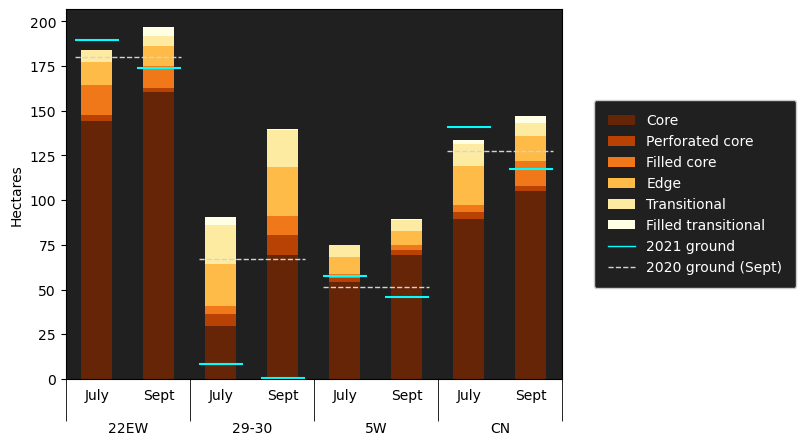

In [46]:
ax = df_pred_wide.sort_index(level=1, ascending=False).sort_index(level=0, sort_remaining=False).plot.bar(
    stacked=True, cmap="YlOrBr_r")
ax.set_facecolor('#202020')
ax.set_ylabel('Hectares')
#ax.xticks(rotation=0)
for idx, past in enumerate(df_val['Pasture'].unique()):
    idx = idx*2
    plt.hlines(y=df_val[(df_val['Pasture'] == past) &
                        (df_val['yrs_thresh'] == 0)]['ha_obs_july'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='cyan')
for idx, past in enumerate(df_val['Pasture'].unique()):
    idx = idx*2+1
    plt.hlines(y=df_val[(df_val['Pasture'] == past) &
                        (df_val['yrs_thresh'] == 0)]['ha_obs'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='cyan')
for idx, past in enumerate(df_val['Pasture'].unique()):
    plt.hlines(y=df_val[(df_val['Pasture'] == past) &
                        (df_val['yrs_thresh'] == 1)]['ha_obs'].values[0],
               xmin=idx*2-0.35, xmax=idx*2+1+0.35,
               color='lightgrey', linestyle='dashed', linewidth=1)
ax.legend(
    handles=ax.get_legend_handles_labels()[0] + [Line2D([0], [0], color='cyan', lw=1, linestyle='solid'),
                                                 Line2D([0], [0], color='lightgrey', lw=1, linestyle='dashed')],
    labels=['Core', 'Perforated core', 'Filled core', 
                   'Edge', 'Transitional', 'Filled transitional', '2021 ground', '2020 ground (Sept)'], 
           bbox_to_anchor=(1.05, 0.5), loc='center left', borderpad=1,
           facecolor='#202020', labelcolor='white', framealpha=1.0)
ax.set_xlabel('')
cur_xticks = df_val['Pasture'].unique()
xticks = []
for i in [0, 2, 4, 6]:
    for x in list(np.arange(0, 1.5, 0.5)):
        xticks.append(i + x)
xlbls = ['July', '\n\n' + cur_xticks[0], 'Sept',
         'July', '\n\n' + cur_xticks[1], 'Sept',
         'July', '\n\n' + cur_xticks[2], 'Sept',
         'July', '\n\n' + cur_xticks[3], 'Sept']

ax.set_xticks(xticks, major=True)
ax.set_xticks([-0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], minor=True)
ax.set_xticklabels(xlbls, rotation=0)
#ax.set_xlim( -0.5, 7.5 )

#ax.grid( 'off', axis='x' )
#ax.grid( 'off', axis='x', which='minor' )

# vertical alignment of xtick labels
#va = [ 0, -.05, 0, -.05, -.05, -.05 ]
#for t, y in zip( ax.get_xticklabels( ), va ):
#    t.set_y( y )

ax.tick_params( axis='x', which='minor', direction='out', length=30 )
ax.tick_params( axis='x', which='major', bottom=False, top=False)

In [185]:
xticks

[[-0.5, 0.0, 0.5], [1.5, 2.0, 2.5], [3.5, 4.0, 4.5], [5.5, 6.0, 6.5]]

In [160]:
cur_xticks[0].get_text()

'(22EW, ha_pred_july)'

(0.0, 1.0)

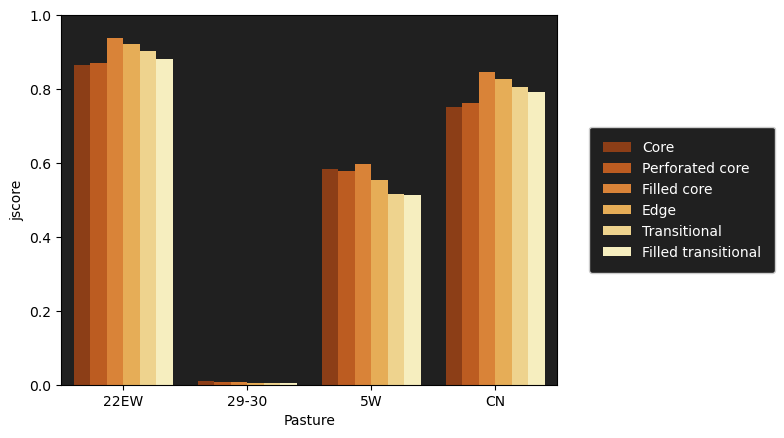

In [101]:
ax = sns.barplot(x='Pasture', y='jscore', hue='conn_thresh', palette="YlOrBr_r",
            data=df_val[df_val['yrs_thresh'] == 0])
ax.set_facecolor('#202020')
ax.legend(
     handles=ax.get_legend_handles_labels()[0],
    labels=['Core', 'Perforated core', 'Filled core', 
                   'Edge', 'Transitional', 'Filled transitional'], 
           bbox_to_anchor=(1.05, 0.5), loc='center left', borderpad=1,
           facecolor='#202020', labelcolor='white', framealpha=1.0)
plt.ylim((0, 1.0))

(0.0, 1.0)

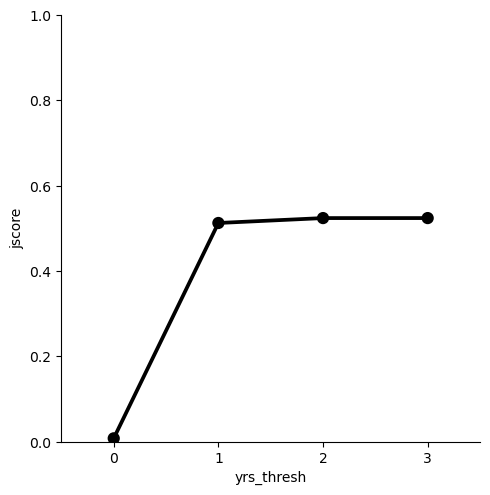

In [103]:
sns.catplot(x='yrs_thresh', y='jscore', kind='point', color='black',
            data=df_val[(df_val['Pasture'] == '29-30') &
                        (df_val['conn_thresh'] == 3)])
plt.ylim((0, 1.0))

### Old code

In [30]:
df_val = pd.DataFrame(columns=['yrs_thresh', 'pts_thresh', 'jscore'])
idx=0
for yrs_thresh in tqdm(range(0, 6)):
    for pts_thresh in range(0, 51, 2):
        df_out['y_true'] = df_out['yrs_active'] > yrs_thresh
        df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
        jscore = jaccard_score(y_true=df_out['y_true'],
                      y_pred=df_out['y_pred'])
        df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': yrs_thresh,
                                                  'pts_density': pts_thresh,
                                                  'jscore': jscore}, index=[idx])])
        idx+=1

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:06<00:00, 11.03s/it]


In [31]:
for pts_thresh in tqdm(range(0, 51, 2)):
    df_out['y_true'] = (df_out['yrs_active'] > 0) | (df_out['yrs_old'] == 1)
    df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': -1,
                                              'pts_density': pts_thresh,
                                              'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:11<00:00,  2.33it/s]


In [32]:
df_out['box_x'] = df_out.apply(lambda x: -1 if x['yrs_old'] == 1 else x['yrs_active'], axis=1)
df_out_boxplot = df_out.loc[df_out['box_x'].notnull()].copy()

In [33]:
df_out_boxplot['box_x'] = df_out_boxplot['box_x'].astype('int')
df_out_boxplot['box_x'].loc[df_out_boxplot['box_x'] == 0] = 'N/A'

/tmp/ipykernel_8366/1536855321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_boxplot['box_x'].loc[df_out_boxplot['box_x'] == 0] = 'N/A'


In [34]:
df_val_smry = pd.DataFrame(df_val.groupby('yrs_thresh').apply(
    lambda x: x['pts_density'][x['jscore'] == x['jscore'].max()])).droplevel(level=1)
df_val_smry['jscore'] = df_val.groupby('yrs_thresh').apply(lambda x: x['jscore'].max())
display(round(df_val_smry, 2))

,pts_density,jscore
yrs_thresh,,
-1,10.0,0.77
0,14.0,0.74
1,16.0,0.70
2,18.0,0.48
3,24.0,0.39
4,28.0,0.21
5,28.0,0.11


In [35]:
pts_thresh = df_val_smry['pts_density'][df_val_smry.index==0][0]

Text(-0.16, 0.975, '(b)')

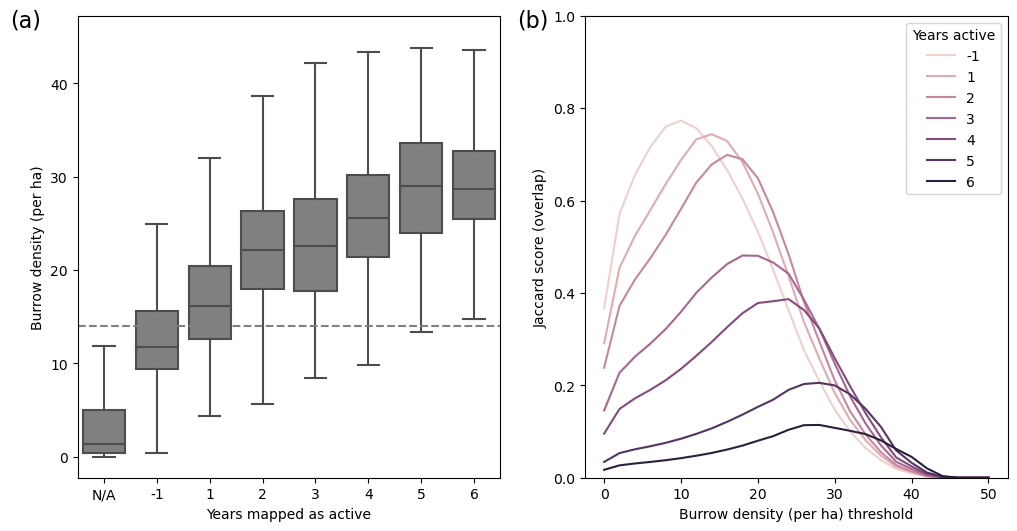

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x='box_x', y='pts_density', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density (per ha)')
axs[0].set_xlabel('Years mapped as active')
axs[0].axhline(y=pts_thresh, linestyle='dashed', color='grey')

sns.lineplot(x='pts_density', y='jscore', data=df_val, hue='yrs_thresh', ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Burrow density (per ha) threshold')
axs[1].set_ylim(0, 1.0)
axs[1].legend(title='Years active', labels=['-1', '1', '2', '3', '4', '5', '6'])

axs[0].annotate('(a)', (-0.16, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.16, 0.975), xycoords='axes fraction', fontsize=16)

#plt.savefig('./results_figs/colony_age_and_burrow_density_plot' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [37]:
df_bm_slope_val = pd.DataFrame(columns=['bm_slope_z', 'jscore'])
idx = 0
for zscore in tqdm(np.arange(-2.0, 2.0, 0.1)):
    df_out['y_true'] = (df_out['yrs_active'] > 0)
    df_out['y_pred'] = (df_out['pts_density'] >= df_val_smry['pts_density'][df_val_smry.index==0][0]) & (df_out['bm_slope_z'] < zscore)
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_bm_slope_val = pd.concat([df_bm_slope_val, pd.DataFrame({'bm_slope_z': zscore,
                                                                'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.33it/s]


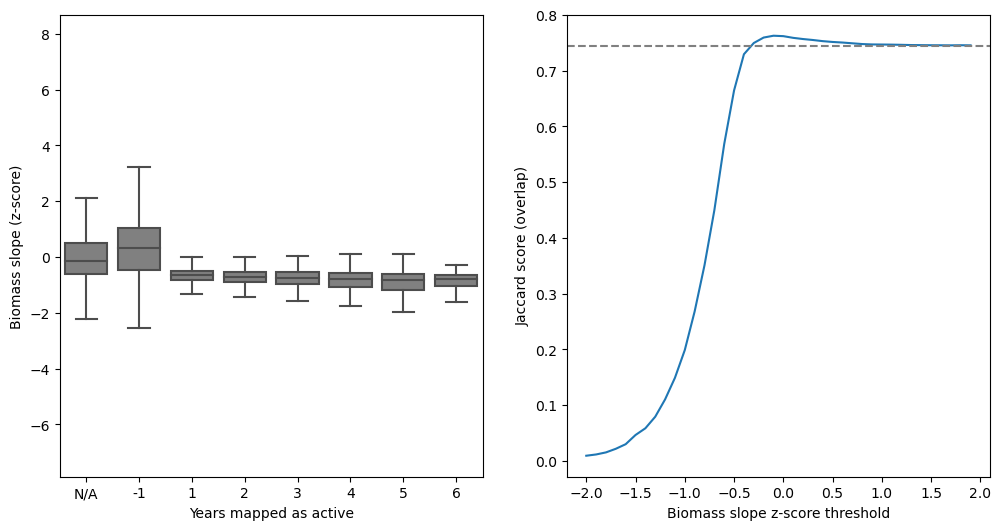

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(x='box_x', y='bm_slope_z', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Biomass slope (z-score)')
axs[0].set_xlabel('Years mapped as active')

sns.lineplot(x='bm_slope_z', y='jscore', data=df_bm_slope_val, ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Biomass slope z-score threshold')
axs[1].axhline(y=df_val_smry['jscore'][df_val_smry.index==0][0], linestyle='dashed', color='grey')

In [39]:
df_bm_slope_val[(df_bm_slope_val['jscore'].max() - df_bm_slope_val['jscore']) < 0.005]

,bm_slope_z,jscore
18,-2.000000e-01,0.759211
19,-1.000000e-01,0.762499
20,1.776357e-15,0.761731
21,1.000000e-01,0.758683


In [40]:
df_bare_val = pd.DataFrame(columns=['bare_z', 'jscore'])
idx = 0
for zscore in tqdm(np.arange(-2.0, 2.0, 0.1)):
    df_out['y_true'] = (df_out['yrs_active'] > 0)
    df_out['y_pred'] = (df_out['pts_density'] >= df_val_smry['pts_density'][df_val_smry.index==0][0]) & (df_out['bare_z'] > zscore)
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_bare_val = pd.concat([df_bare_val, pd.DataFrame({'bare_z': zscore,
                                                                'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.33it/s]


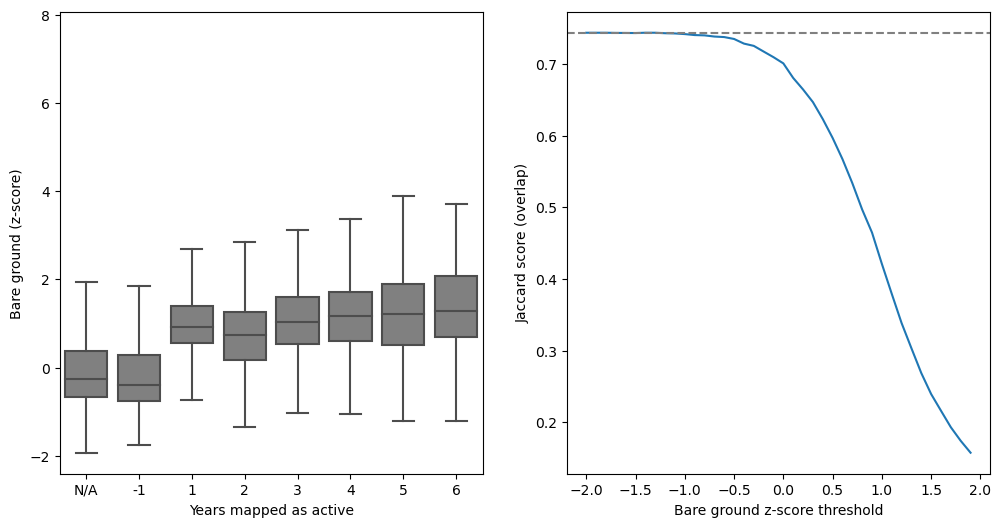

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(x='box_x', y='bare_z', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Bare ground (z-score)')
axs[0].set_xlabel('Years mapped as active')

sns.lineplot(x='bare_z', y='jscore', data=df_bare_val, ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Bare ground z-score threshold')
axs[1].axhline(y=df_val_smry['jscore'][df_val_smry.index==0][0], linestyle='dashed', color='grey')

In [42]:
df_bare_val[(df_bare_val['jscore'].max() - df_bare_val['jscore']) < 0.005]

,bare_z,jscore
0,-2.0,0.743554
1,-1.9,0.743554
2,-1.8,0.743554
3,-1.7,0.743332
4,-1.6,0.743244
5,-1.5,0.743130
6,-1.4,0.743581
7,-1.3,0.743552
8,-1.2,0.742888
9,-1.1,0.742572


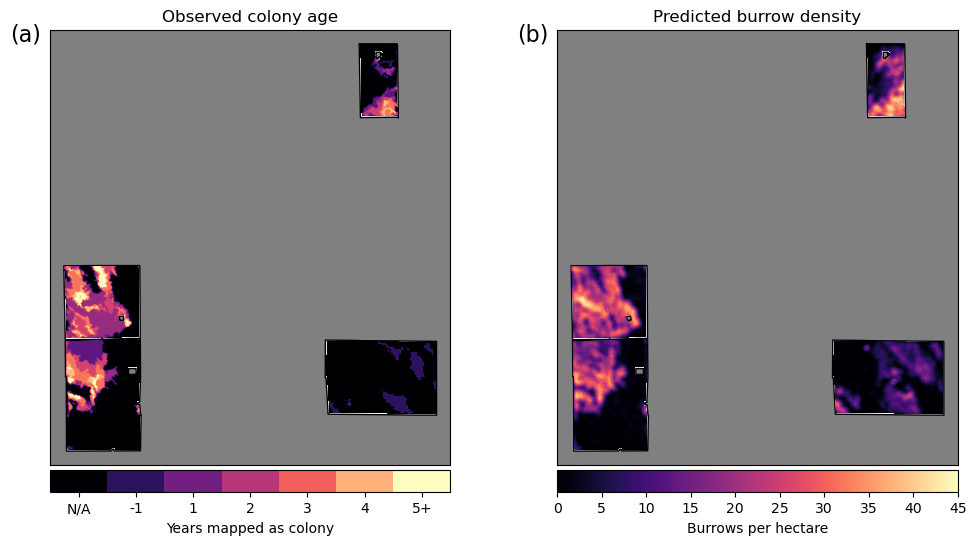

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
cmap_density = 'magma'
pts_thresh = df_val_smry['pts_density'][df_val_smry.index==0][0]
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plot_buff_m = 300
cper.plot(fc='white', ec='black', ax=axs[0])
show(da_active.data, ax=axs[0], transform=da_active.rio.transform(), zorder=5, cmap=cmap_density)
show(da_old.where(da_old == 1).data, ax=axs[0], transform=da_old.rio.transform(), clim=(0, 6), zorder=8, cmap=cmap_density)
p_active = show(da_active.where(da_active > 0).data, ax=axs[0], transform=da_active.rio.transform(),
                clim=(-1, 6), zorder=10, cmap=cmap_density)
axs[0].set_title('Observed colony age')

cper.plot(fc='white', ec='black', ax=axs[1])
p_density = show(pts_density_xr.data, ax=axs[1], transform=pts_density_xr.rio.transform(), zorder=10, cmap=cmap_density)
axs[1].set_title('Predicted burrow density')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
    ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
    ax.set_facecolor('grey')
axs[0].annotate('(a)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)

# colorbar for first plot
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = ColorbarBase(ax=cax1, 
                     cmap=plt.get_cmap(cmap_density, 7), 
                     norm=BoundaryNorm(np.arange(0, 8), 8),
                     ticks=np.arange(0.5, 7.5),
                     label='Years mapped as colony',
                     orientation='horizontal')
cbar1.ax.set_xticklabels(['N/A', -1, 1, 2, 3, 4, '5+'])  # horizontal colorbar

# colorbar for second plot
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(p_density.get_images()[0],
             cax=cax2,
             orientation='horizontal', 
             label='Burrows per hectare')
#plt.savefig('./results_figs/colony_age_and_burrow_density_map' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [47]:
bm_slope_thresh = -0.2
colony_thresh = ((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).astype('float')
#colony_thresh.rio.to_raster('./cnn_pred_results/tifs/colony_threshold' + suffix + '_5ha_with_bm.tif')

In [42]:
from scipy.stats import gaussian_kde
#df_out_sub = df_out[(df_out['yrs_active'] > 0) | (df_out['yrs_old'] == 1)].dropna(subset=['pts_density', 'bm_slope_z']).sample(n=5000)
df_out_sub = df_out.dropna(subset=['pts_density', 'bm_slope_z', 'bm', 'bare']).sample(n=10000)

In [43]:
xy_bm = np.vstack([df_out_sub['pts_density'], df_out_sub['bm']])
z_bm = gaussian_kde(xy_bm)(xy_bm)

xy_bare = np.vstack([df_out_sub['pts_density'], df_out_sub['bare']])
z_bare = gaussian_kde(xy_bare)(xy_bare)

xy_bm_slope = np.vstack([df_out_sub['pts_density'], df_out_sub['bm_slope_z']])
z_bm_slope = gaussian_kde(xy_bm_slope)(xy_bm_slope)

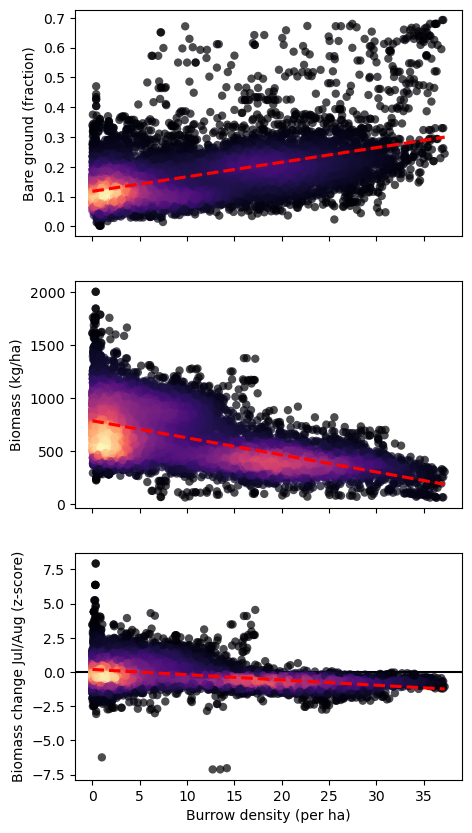

In [44]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(5, 10))
sns.scatterplot(x='pts_density', y='bare', data=df_out_sub, 
                c=z_bare, cmap='magma', ec='none', alpha=0.7, ax=axs[0])
sns.regplot(x='pts_density', y='bare', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed'), ax=axs[0])
sns.scatterplot(x='pts_density', y='bm', data=df_out_sub, 
                c=z_bm, cmap='magma', ec='none', alpha=0.7, ax=axs[1])
sns.regplot(x='pts_density', y='bm', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed'), ax=axs[1])
sns.scatterplot(x='pts_density', y='bm_slope_z', data=df_out_sub, 
                c=z_bm_slope, cmap='magma', ec='none', alpha=0.7, ax=axs[2], zorder=10)
sns.regplot(x='pts_density', y='bm_slope_z', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed', zorder=11), ax=axs[2])
axs[2].axhline(y=0, linestyle='solid', color='black', zorder=1)
axs[0].set_ylabel('Bare ground (fraction)')
axs[1].set_ylabel('Biomass (kg/ha)')
axs[2].set_ylabel('Biomass change Jul/Aug (z-score)')
axs[2].set_xlabel('Burrow density (per ha)')
#plt.savefig('./results_figs/burrow_density_and_satellite_metrics' + suffix + '_20ha.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [86]:
past_bounds = cper[cper['Past_Name_'] == '29-30'].geometry.bounds

In [87]:
df_out_boxplot_sub = df_out_boxplot.reset_index()

In [88]:
df_out_boxplot_sub = df_out_boxplot_sub[(df_out_boxplot_sub['x'] > past_bounds['minx'].values[0]) & 
                                        (df_out_boxplot_sub['x'] < past_bounds['maxx'].values[0]) & 
                                        (df_out_boxplot_sub['y'] > past_bounds['miny'].values[0]) &
                                        (df_out_boxplot_sub['y'] < past_bounds['maxy'].values[0])]

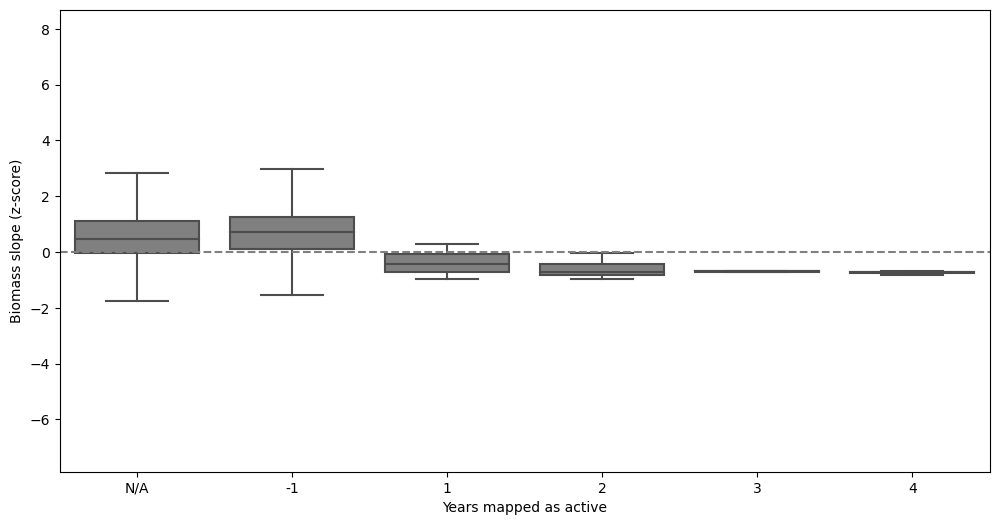

In [94]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
sns.boxplot(x='box_x', y='bm_slope_z', 
            data=df_out_boxplot_sub,
            order=['N/A', -1, 1, 2, 3, 4],
            fliersize=0, color='grey', ax=ax)
ax.set_ylabel('Biomass slope (z-score)')
ax.set_xlabel('Years mapped as active')
ax.axhline(y=0, linestyle='dashed', color='grey')
plt.savefig('./results_figs/bm_slope_vs_years_active_2930.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [44]:
colony_thresh = (pts_density_xr >= pts_thresh).astype('float')
colony_thresh.rio.to_raster('./cnn_pred_results/tifs/colony_threshold' + suffix + '.tif')

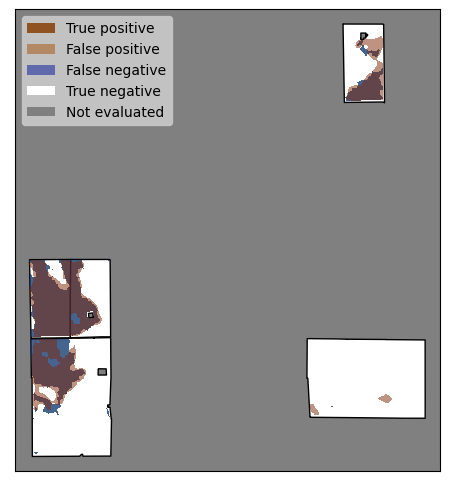

In [40]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where(pts_density_xr >= pts_thresh).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [41]:
pts_thresh

10.0

In [42]:
print('Colony area predicted from burrow density: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('False positive area: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (da_active <= 0)).sum()*5.0**2*0.0001).values, 1), 'ha')

print('False negative area: ')
print('  ', np.round((((pts_density_xr < pts_thresh) & (da_active > 0)).sum()*5.0**2*0.0001).values, 1), 'ha')


print('---------------')
print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   362.8 ha
Colony area mapped in 2021: 
   337.8 ha
False positive area: 
   56.9 ha
False negative area: 
   31.9 ha
---------------
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   353.1 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha


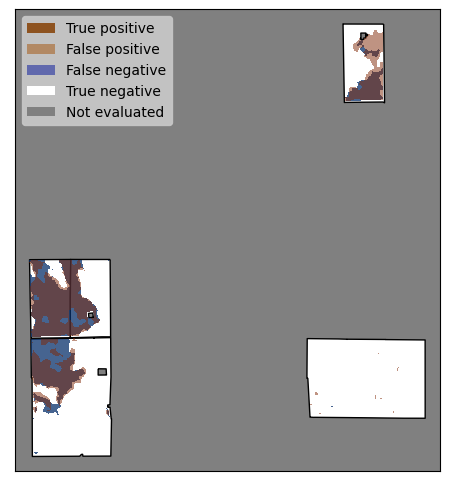

In [40]:
bm_slope_thresh = -0.1

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + 'with_bm_thresh.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [41]:
print('Colony area predicted from burrow density: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   347.1 ha
Colony area mapped in 2021: 
   337.8 ha
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   337.9 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha


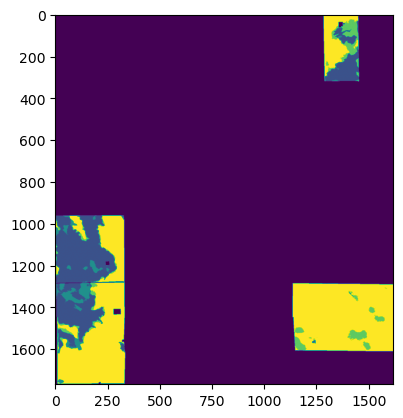

<AxesSubplot:>

In [42]:
da_result = xr.zeros_like(da_active)
da_result = da_result + ((da_active > 0) & (pts_density_xr >= pts_thresh))
da_result = da_result + ((da_active > 0) & (pts_density_xr < pts_thresh)) * 2
da_result = da_result + ((da_active == 0) & (pts_density_xr >= pts_thresh)) * 3
da_result = da_result + ((da_active == 0) & (pts_density_xr < pts_thresh)) * 4
show(da_result.data, clim=(0, 4))

In [43]:
pred_result_dict = {
    0: np.nan,
    1: 'True positive',
    2: 'False negative',
    3: 'False positive',
    4: 'True negative'
}
df_out['pred_result'] = da_result.to_dataframe(name='pred_result')['pred_result'].apply(lambda x: pred_result_dict[x])

In [44]:
from skimage.measure import label, regionprops
pr_burrow_labels = label((pts_density_xr >= pts_thresh))
pr_burrow_regions = regionprops(pr_burrow_labels)

pr_non_labels = label((pts_density_xr < pts_thresh))
pr_non_regions = regionprops(pr_non_labels)

In [45]:
area_thresh = 30
sm_burrow_labels = [x.label for x in pr_burrow_regions if (x.area * (cell_size**2 * 10e-4)) < area_thresh]
sm_non_labels = [x.label for x in pr_non_regions if (x.area * (cell_size**2 * 10e-4)) < area_thresh]
xr_burrow_labels = (xr.ones_like(pts_density_xr) * pr_burrow_labels).astype('int')
xr_non_labels = (xr.ones_like(pts_density_xr) * pr_non_labels).astype('int')

In [46]:
df_out['sm_burrow_area'] = xr_burrow_labels.where(
    xr_burrow_labels.isin(sm_burrow_labels)).to_dataframe(
    name='sm_burrow_labels')['sm_burrow_labels'].notnull()
df_out['sm_non_area'] = xr_non_labels.where(
    xr_non_labels.isin(sm_non_labels)).to_dataframe(
    name='sm_non_labels')['sm_non_labels'].notnull()
df_out['sm_area'] = df_out['sm_burrow_area'] | df_out['sm_non_area']

<AxesSubplot:>

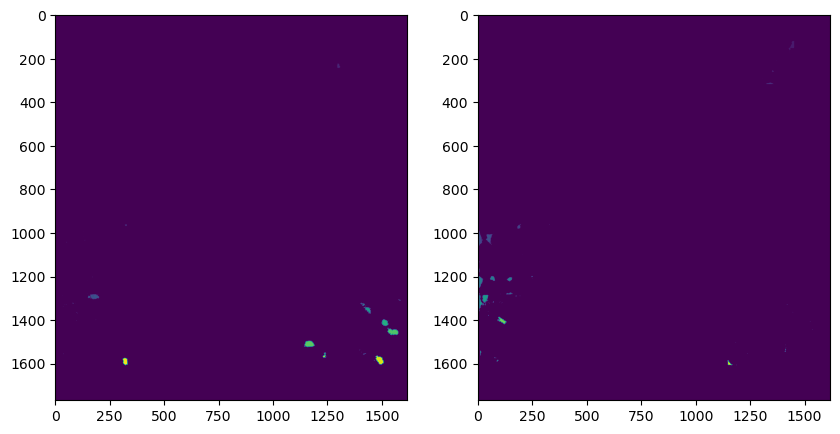

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 6))
show(xr_burrow_labels.where(xr_burrow_labels.isin(sm_burrow_labels), other=-1).data, ax=axs[0])
show(xr_non_labels.where(xr_non_labels.isin(sm_non_labels), other=-1).data, ax=axs[1])

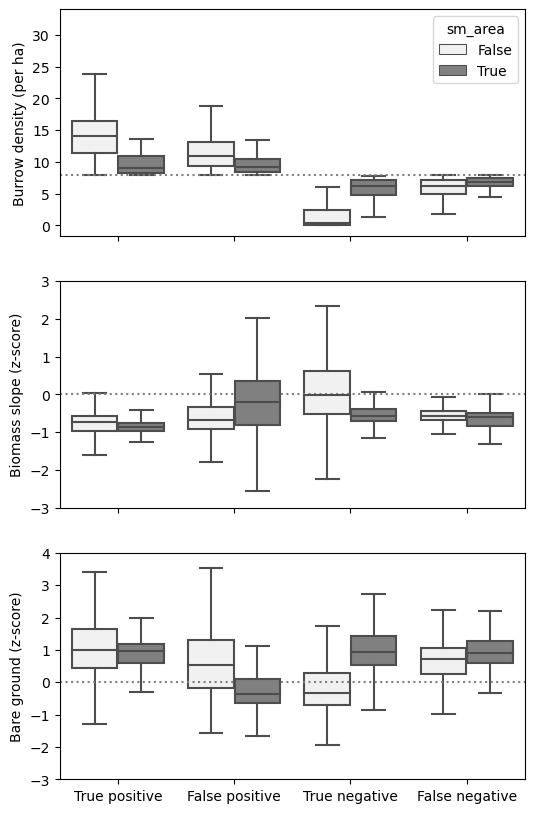

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

In [48]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 10),
            sharex=True)
sns.boxplot(x='pred_result', y='pts_density', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density (per ha)')
axs[0].set_xlabel('')
axs[0].axhline(y=pts_thresh, linestyle='dotted', color='grey')

sns.boxplot(x='pred_result', y='bm_slope_z', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[1])
axs[1].set_ylabel('Biomass slope (z-score)')
axs[1].set_xlabel('')
axs[1].set_ylim(-3.0, 3.0)
axs[1].legend().remove()
axs[1].axhline(y=0, linestyle='dotted', color='grey')

sns.boxplot(x='pred_result', y='bare_z', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[2])
axs[2].set_ylabel('Bare ground (z-score)')
axs[2].set_xlabel('')
axs[2].set_ylim(-3.0, 4.0)
axs[2].legend().remove()
axs[2].axhline(y=0, linestyle='dotted', color='grey')